# Variable time measurement for timestamp XPCS @ CSX

### Preparation

In [62]:
import numpy as np

from dataportal import DataBroker as db, get_table
from csxtools.utils import get_fastccd_images, get_images_to_3D, get_images_to_4D, fccd_mask, get_fastccd_flatfield, get_fastccd_timestamps 
from csxtools.image import stackmean, images_mean, images_sum
from csxtools.ipynb import image_stack_to_movie, show_image_stack #, notebook_to_nbviewer

from skbeam.core import recip
from skbeam.core.utils import grid3d
import skbeam.core.roi as roi
import skbeam.core.correlation as corr
import skbeam.core.utils as utils

import xray_vision
import xray_vision.mpl_plotting as mpl_plot  

import matplotlib.pyplot as plt
%matplotlib notebook

from ipywidgets import interact
import numpy.ma as ma

import time as ttime

### Detector calibration

In [2]:
flat_scans = [59641]
dark_scans = [59708]
dark = db[dark_scans]
flat = db[flat_scans]

In [3]:
ff = get_fastccd_flatfield(flat, (dark, None, None), flat=fccd_mask(), limits=(0.8, 1.2))

<IPython.core.display.Javascript object>


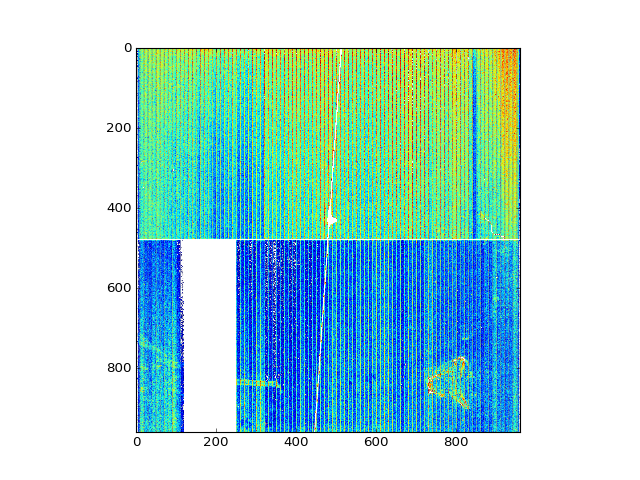

In [4]:
fig, ax = plt.subplots(1)
ax.imshow(ff)

### The measurement

In [5]:
light_scans = (60015)

In [6]:
light = db[light_scans]
images = get_fastccd_images(light, (dark, None, None), flat=ff)
stack = get_images_to_4D(images)
stack.shape

(300, 50, 960, 960)

In [ ]:
np.save("stack.npy", stack)

In [7]:
images_sq = np.nanmean(stack, axis = 1)

/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [8]:
images_sq.shape

(300, 960, 960)

In [ ]:
np.save("images_sq.npy", images_sq)

In [ ]:
%matplotlib inline
image_stack_to_movie(images_sq, vmin=0, vmax=200, figsize=(12, 10))

In [15]:
%matplotlib notebook

In [16]:
images_pnt = stackmean(images)

In [17]:
images_pnt.shape

(960, 960)

In [507]:
np.save("images_pnt.npy", images_pnt)

<IPython.core.display.Javascript object>


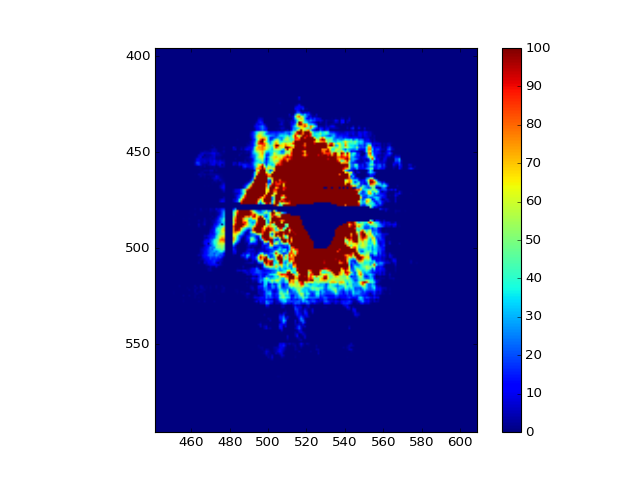

In [18]:
fig, ax = plt.subplots(1)
pippo = ax.imshow(images_pnt, vmin = 0, vmax = 100)
plt.colorbar(pippo)

# Retrieve timestamps from the data

In [12]:
from dataportal import get_events
from csxtools.handlers import AreaDetectorHDF5TimestampHandler
def get_fastccd_timestamps(header, tag='fccd_image'):
    """Return the FastCCD timestamps from the Areadetector Data File

    Return a list of numpy arrays of the timestamps for the images as
    recorded in the datafile.

    Parameters
    ----------
    header : databorker header
        This header defines the run

    Returns
    -------
        list of arrays of the timestamps

    """
    hover = {tag: AreaDetectorHDF5TimestampHandler}
    
    
    img = [i for i in get_events(header, [tag],
                                 handler_overrides=hover)]
    
    timestamps = [i['data'][tag] for i in img if tag in i['data'].keys()]
    return timestamps


In [13]:
data_stamps = get_fastccd_timestamps(light)

In [ ]:
np.save("data_stamps.npy", data_stamps)

In [14]:
p =np.ravel(data_stamps)
p.shape

(15000,)

In [19]:
pippo, pluto = np.histogram(p, bins=300)

<IPython.core.display.Javascript object>


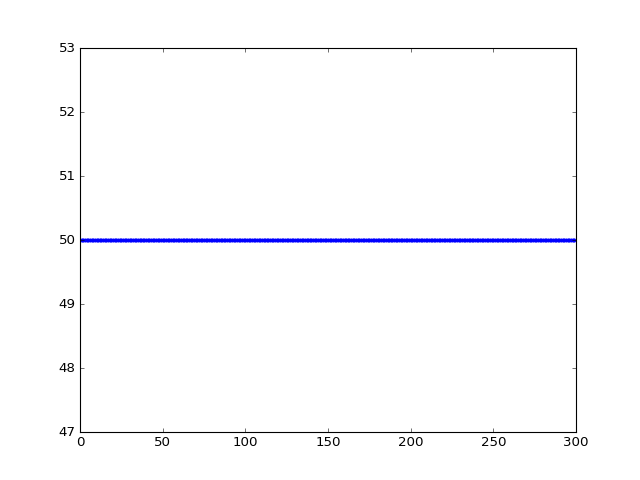

In [20]:
fig, ax= plt.subplots(1)
ax.plot(pippo, '.')
plt.show()

In [21]:
y = list(p)
len(y)

15000

In [22]:
ty = y[:51]
ty[0]

826789533.30000091

##  Get the time steps 

In [35]:
img_time = []
for i in y:
    img_time.append(((i - y[0])))

In [36]:
len(img_time)

15000

In [37]:
list(map(int, img_time[:51]))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 30]

In [141]:
img_time[0:100]

[0.0,
 0.00597381591796875,
 0.01165616512298584,
 0.017603754997253418,
 0.023381948471069336,
 0.029430627822875977,
 0.035067081451416016,
 0.041174530982971191,
 0.046843171119689941,
 0.052919745445251465,
 0.058518528938293457,
 0.064460992813110352,
 0.081182718276977539,
 0.10116851329803467,
 0.12104332447052002,
 0.14114761352539062,
 0.16121125221252441,
 0.1812598705291748,
 0.2012401819229126,
 0.22122097015380859,
 0.24112975597381592,
 0.26124536991119385,
 0.28120613098144531,
 0.30130124092102051,
 0.32114577293395996,
 0.34159433841705322,
 0.36117994785308838,
 0.38122916221618652,
 0.40130949020385742,
 0.42117416858673096,
 0.44119167327880859,
 0.46118390560150146,
 0.48169124126434326,
 0.50120270252227783,
 0.52138149738311768,
 0.54143548011779785,
 0.56162941455841064,
 0.58149099349975586,
 0.60192966461181641,
 0.62131226062774658,
 0.64122676849365234,
 0.6618269681930542,
 0.68156898021697998,
 0.70121729373931885,
 0.72136127948760986,
 0.7412298917770385

<IPython.core.display.Javascript object>


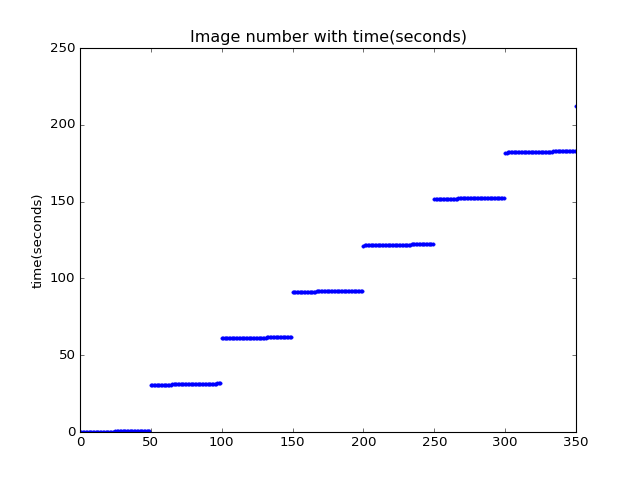

In [418]:
fig, ax= plt.subplots(1)
ax.plot(img_time[:351], ".")
ax.set_title("Image number with time(seconds)")
ax.set_ylabel("time(seconds)")
ax.set_label("image number")
plt.show()

# time difference from previous image

In [358]:
t_diff = []
for i, v in enumerate(img_time):
    t_diff.append((v - img_time[i-1]))
t_diff[0]=0    

In [ ]:
np.save("t_diff.npy", np.asarray(t_diff))

In [439]:
t_diff_r = np.round(np.asarray(t_diff),2)
t_diff_r[:101]

array([  0.00000000e+00,   1.00000000e-02,   1.00000000e-02,
         1.00000000e-02,   1.00000000e-02,   1.00000000e-02,
         1.00000000e-02,   1.00000000e-02,   1.00000000e-02,
         1.00000000e-02,   1.00000000e-02,   1.00000000e-02,
         2.00000000e-02,   2.00000000e-02,   2.00000000e-02,
         2.00000000e-02,   2.00000000e-02,   2.00000000e-02,
         2.00000000e-02,   2.00000000e-02,   2.00000000e-02,
         2.00000000e-02,   2.00000000e-02,   2.00000000e-02,
         2.00000000e-02,   2.00000000e-02,   2.00000000e-02,
         2.00000000e-02,   2.00000000e-02,   2.00000000e-02,
         2.00000000e-02,   2.00000000e-02,   2.00000000e-02,
         2.00000000e-02,   2.00000000e-02,   2.00000000e-02,
         2.00000000e-02,   2.00000000e-02,   2.00000000e-02,
         2.00000000e-02,   2.00000000e-02,   2.00000000e-02,
         2.00000000e-02,   2.00000000e-02,   2.00000000e-02,
         2.00000000e-02,   2.00000000e-02,   2.00000000e-02,
         2.00000000e-02,

In [437]:
t_diff_r = np.where(t_diff_r < 1.70000000e-02)

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11, 4474]),)

In [438]:
t_diff[102:201]

[0.019964218139648438,
 0.019732475280761719,
 0.019749641418457031,
 0.02059626579284668,
 0.019304752349853516,
 0.020946264266967773,
 0.020573735237121582,
 0.019704341888427734,
 0.020242571830749512,
 0.019183635711669922,
 0.019936919212341309,
 0.020993590354919434,
 0.018512248992919922,
 0.021109819412231445,
 0.019498229026794434,
 0.020539402961730957,
 0.020529270172119141,
 0.019050359725952148,
 0.020444273948669434,
 0.0190887451171875,
 0.021910309791564941,
 0.018006205558776855,
 0.020715951919555664,
 0.020665645599365234,
 0.018504142761230469,
 0.019845962524414062,
 0.020044088363647461,
 0.02173006534576416,
 0.019327521324157715,
 0.01996767520904541,
 0.018961668014526367,
 0.020173192024230957,
 0.020624279975891113,
 0.020341634750366211,
 0.019153475761413574,
 0.019802212715148926,
 0.019815444946289062,
 0.021640658378601074,
 0.018578648567199707,
 0.019968748092651367,
 0.019877314567565918,
 0.020029187202453613,
 0.020168185234069824,
 0.0210506916046

<IPython.core.display.Javascript object>


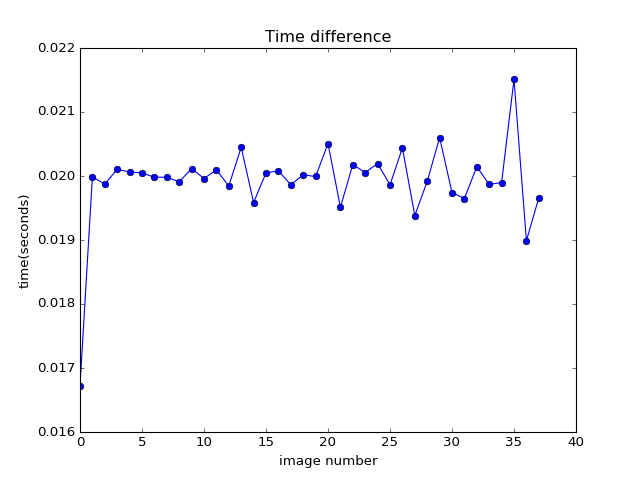

In [417]:
fig, ax= plt.subplots(1)
ax.plot(t_diff[12:50], "-o")
ax.set_title("Time difference")
ax.set_ylabel("time(seconds)")
ax.set_xlabel("image number")
plt.show()

## time difference from previous two images

In [55]:
t_diff2 = []
for i, v in enumerate(img_time):
    t_diff2.append((v - img_time[i-2]))
    

In [56]:
t_diff2[:51]

[-9053.1396324634552,
 -9053.1537395715714,
 0.01165616512298584,
 0.011629939079284668,
 0.011725783348083496,
 0.011826872825622559,
 0.01168513298034668,
 0.011743903160095215,
 0.011776089668273926,
 0.011745214462280273,
 0.011675357818603516,
 0.011541247367858887,
 0.022664189338684082,
 0.036707520484924316,
 0.03986060619354248,
 0.039979100227355957,
 0.040167927742004395,
 0.04011225700378418,
 0.040028929710388184,
 0.039961099624633789,
 0.03988957405090332,
 0.040024399757385254,
 0.040076375007629395,
 0.04005587100982666,
 0.039939641952514648,
 0.040293097496032715,
 0.040034174919128418,
 0.039634823799133301,
 0.040129542350769043,
 0.039945006370544434,
 0.039882183074951172,
 0.040009737014770508,
 0.040499567985534668,
 0.040018796920776367,
 0.039690256118774414,
 0.04023277759552002,
 0.040247917175292969,
 0.040055513381958008,
 0.040300250053405762,
 0.039821267127990723,
 0.039297103881835938,
 0.040514707565307617,
 0.040342211723327637,
 0.03939032554626464

In [29]:
img_time[51:65]

[30.66,
 30.68,
 30.699999999999999,
 30.719999999999999,
 30.739999999999998,
 30.760000000000002,
 30.780000000000001,
 30.800000000000001,
 30.82,
 30.84,
 30.859999999999999,
 30.879999999999999,
 30.899999999999999,
 30.920000000000002]

<IPython.core.display.Javascript object>


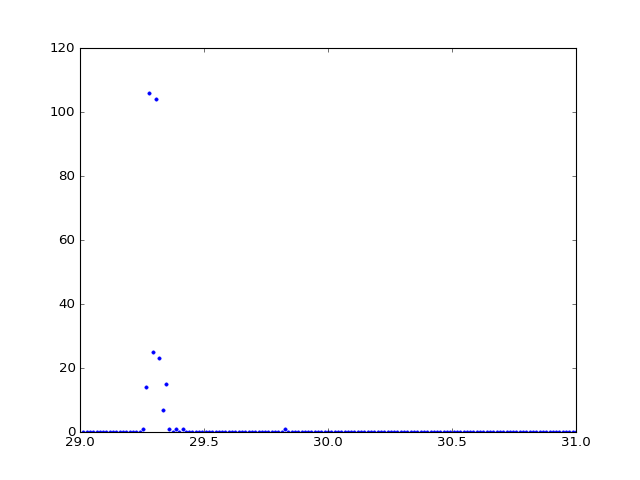

In [54]:
#hist_d, binsd = np.histogram(t_diff[1:], bins=150, range=(0,.05))
hist_d, binsd = np.histogram(t_diff[1:], bins=150, range=(29,31))

fig, ax= plt.subplots(1)
ax.plot(binsd[1:],hist_d, ".")
plt.show()

In [46]:
hist_d[:100]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>


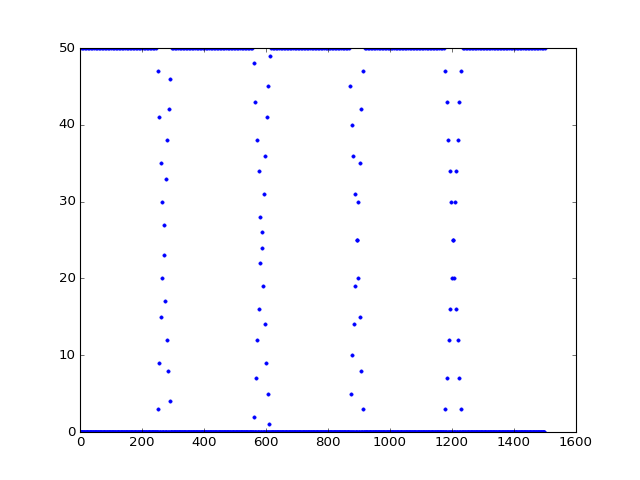

In [31]:
hist1, bins1 = np.histogram(img_time, bins=1500)

fig, ax= plt.subplots(1)
ax.plot(hist1, ".")
plt.show()

<IPython.core.display.Javascript object>


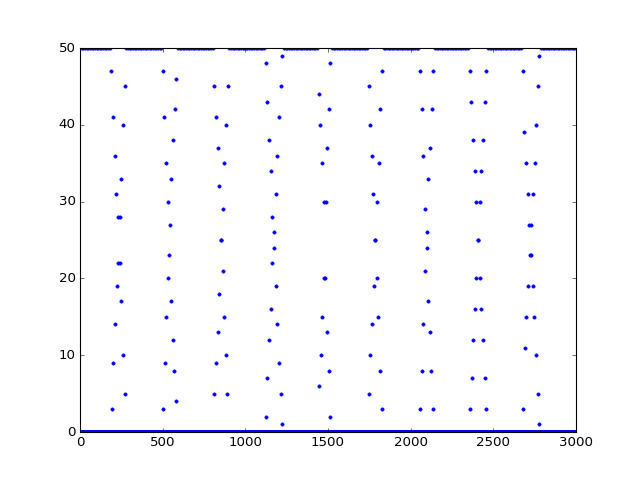

In [32]:
hist, bins = np.histogram(img_time,bins=3000)

fig, ax= plt.subplots(1)
ax.plot(hist, ".")
plt.show()

In [33]:
hist[:400]

array([50,  0,  0,  0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,
        0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0, 50,
        0,  0,  0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0,
        0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,
        0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0, 50,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0,
        0, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0, 50,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       50,  0,  0,  0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 47,  3,  0,  0,  0,  0,  0,  0,  0,  0, 41,  9,  0,  0,
        0,  0,  0,  0,  0,  0, 36, 14,  0,  0,  0,  0,  0,  0,  0,  0, 31,
       19,  0,  0,  0,  0

In [34]:
image_r = stack.reshape(15000, 960, 960)

In [57]:
import matplotlib.cm as mcm
from matplotlib.colors import LogNorm

def show_label_array_on_image(ax, image, label_array, cmap=None,
                              imshow_cmap='gray', norm=LogNorm(), **kwargs):
    """
    This will plot the required ROI's(labeled array) on the image
    Additional kwargs are passed through to `ax.imshow`.
    If `vmin` is in kwargs, it is clipped to minimum of 0.5.
    Parameters
    ----------
    ax : Axes
        The `Axes` object to add the artist too
    image : array
        The image array
    label_array : array
        Expected to be an unsigned integer array.  0 is background,
        positive integers label region of interest
    cmap : str or colormap, optional
        Color map to use for plotting the label_array, defaults to 'None'
    imshow_cmap : str or colormap, optional
        Color map to use for plotting the image, defaults to 'gray'
    norm : str, optional
        Normalize scale data, defaults to 'Lognorm()'
    Returns
    -------
    im : AxesImage
        The artist added to the axes
    im_label : AxesImage
        The artist added to the axes
    """
    ax.set_aspect('equal')
    im = ax.imshow(image, cmap=imshow_cmap, interpolation='none', norm=norm,
                   **kwargs)
    im_label = mpl_plot.show_label_array(ax, label_array, cmap=cmap, norm=norm,
                                **kwargs)
    return im, im_label

<IPython.core.display.Javascript object>


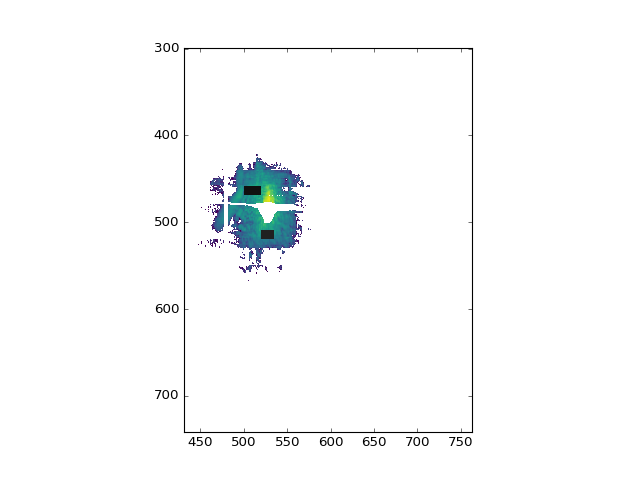

In [58]:
roi_data = np.array(([460, 500, 10, 20], [510, 520, 10, 15]),
                        dtype=np.int64)
label_array = roi.rectangles(roi_data, images_pnt.shape)

fig, ax = plt.subplots()
im = show_label_array_on_image(ax, images_pnt, label_array,
                               imshow_cmap='viridis', cmap='gray')
plt.show()

In [59]:
def one_time_using_time_stamps(images_stack, time_stamps,
                               labels, num_bufs):
    """
    images_stack :  4D array
    time_stamps : list
        real time taken to collect each image as a list
    labels : array
        Labeled array of the same shape as the image stack.
        Each ROI is represented by sequential integers starting at one.  For
        example, if you have four ROIs, they must be labeled 1, 2, 3,
        4. Background is labeled as 0
     num_bufs : int
        maximum lag step to compute in each generation of downsampling

    """
    num_levels = 1   # todo higher levels
    label_array = []
    pixel_list = []

    label_array, pixel_list = roi.extract_label_indices(labels)
    # map the indices onto a sequential list of integers starting at 1
    label_mapping = {label: n+1
                     for n, label in enumerate(np.unique(label_array))}
    # remap the label array to go from 1 -> max(_labels)
    for label, n in label_mapping.items():
        label_array[label_array == label] = n

    # number of ROI's
    num_rois = len(label_mapping)

    # stash the number of pixels in the mask
    num_pixels = np.bincount(label_array)[1:]

    # to increment buffer
    cur = np.ones(num_levels, dtype=np.int64)

    time_bin, all_times = time_binning(time_stamps)

    # G holds the un normalized auto- correlation result. We
    # accumulate computations into G as the algorithm proceeds.
    G = np.zeros((len(all_times), num_rois), dtype=np.float64)
    # matrix for normalizing G into g2

    past_intensity = np.zeros_like(G)
    # matrix for normalizing G into g2
    future_intensity = np.zeros_like(G)

    buf = np.zeros((num_levels, num_bufs, len(pixel_list)),
                   dtype=np.float64)

    time_track = np.zeros_like(all_times, dtype=np.int64)

    # if internal_state is None:
    # internal_state = _init_state_one_time(num_levels, num_bufs, labels)
    # create a shorthand reference to the results and state named tuple
    # s = internal_state
    j = 0
    for im in images_stack:
        for image in im:
            # Compute the correlations for all higher levels.
            timing = time_bin[j]
            level = 0
            j +=1
            # increment buffer
            cur[0] = (1 + cur[0]) % num_bufs
            #print (timing)

            # Put the ROI pixels into the ring buffer.
            buf[0, cur[0] - 1] = np.ravel(image)[pixel_list]
            buf_no = cur[0] - 1

            #print("timing",timing)

            # Compute the correlations between the first level
            # (undownsampled) frames. This modifies G,
            # past_intensity, future_intensity,
            # and img_per_level in place!
            _one_time_process_time_stamps(buf, G, past_intensity,
                                          future_intensity, label_array,
                                          num_bufs, num_pixels, time_track,
                                          level, buf_no, timing, all_times)

            #TODO higher levels for multi tau

    #print ("G", G)
    #print ("past_intensity", past_intensity)
    #print ("future_intensity", future_intensity)

    # If any past intensities are zero, then g2 cannot be normalized at
    # those levels. This if/else code block is basically preventing
    # divide-by-zero errors.
    if len(np.where(past_intensity == 0)[0]) != 0:
        g_max = np.where(past_intensity == 0)[0][0]
    else:
        g_max = past_intensity.shape[0]

    g2 = (G[:g_max]/ (past_intensity[:g_max] *
                             future_intensity[:g_max]))
    return g2, all_times


def time_binning(time_stamps):
    """
    Parameters
    ----------
    time_stamps : list
        real time taken to collect each image as a list

    Returns
    -------
    time_bin : list
        time bin for each delay time according to time stamps
    all_times : array
        delay time bins according to time stamps
    """
    time_bin = []
    all_times = [0]
    for c, t in enumerate(time_stamps):
        time = [0]
        stamp = 0
        for item in (time_stamps[:c][::-1]):
            stamp += item
            time.append(stamp)
            all_times.append(stamp)
        time_bin.append(time)
    return time_bin, np.unique(np.sort(all_times))


def _one_time_process_time_stamps(buf, G, past_intensity_norm,
                                  future_intensity_norm, label_array,
                                  num_bufs, num_pixels, time_track, level,
                                  buf_no, time_bin, all_time):
    """Reference implementation of the inner loop
     of lazy_one_time_using_time_stamps

    This helper function calculates G, past_intensity_norm and
    future_intensity_norm at each level, symmetric normalization is used.

    .. warning :: This modifies inputs in place.

    Parameters
    ----------
    buf : array
        image data array to use for correlation
    G : array
        matrix of auto-correlation function without normalizations
    past_intensity_norm : array
        matrix of past intensity normalizations
    future_intensity_norm : array
        matrix of future intensity normalizations
    label_array : array
        labeled array where all nonzero values are ROIs
    num_bufs : int, even
        number of buffers(channels)
    num_pixels : array
        number of pixels in certain ROI's
        ROI's, dimensions are : [number of ROI's]X1
    img_per_level : array
        to track how many images processed in each level
    level : int
        the current multi-tau level
    buf_no : int
        the current buffer number
    time_bin : list
        list of time binning

    Notes
    -----
    .. math::
        G = <I(\tau)I(\tau + delay)>
    .. math::
        past_intensity_norm = <I(\tau)>
    .. math::
        future_intensity_norm = <I(\tau + delay)>
    """
    for i, item in enumerate(time_bin):
        # compute the index into the autocorrelation matrix
        ii = np.where(all_time == item)[0]
        time_track[ii] += 1

        delay_no = (buf_no - i) % num_bufs

        #print ("delay_no", delay_no)
        #print ("buf_no", buf_no)

        # get the images for correlating
        past_img = buf[level, delay_no]
        future_img = buf[level, buf_no]

        # find the normalization that can work both for bad_images
        #  and good_images
        #ind = int(t_index - lev_len[:level].sum())
        #normalize = track_time[level] - i - norm[level+1][ind]

        # take out the past_ing and future_img created using bad images
        # (bad images are converted to np.nan array)
        #if np.isnan(past_img).any() or np.isnan(future_img).any():
        #    norm[level + 1][ind] += 1
        #else:
        for w, arr in zip([past_img*future_img, past_img, future_img],
                              [G, past_intensity_norm, future_intensity_norm]):
                binned = np.bincount(label_array, weights=w)[1:]
                arr[ii] += ((binned / num_pixels -
                             arr[ii]) / time_track[ii])
    return None  # modifies arguments in place!




In [83]:
g2_time_stamps1, all_time1 = one_time_using_time_stamps(stack[:5],
                                                      img_time[:250],
                                                      label_array, 500)

In [91]:
all_time1.shape, g2_time_stamps1.shape

((30877,), (30877, 2))

<IPython.core.display.Javascript object>


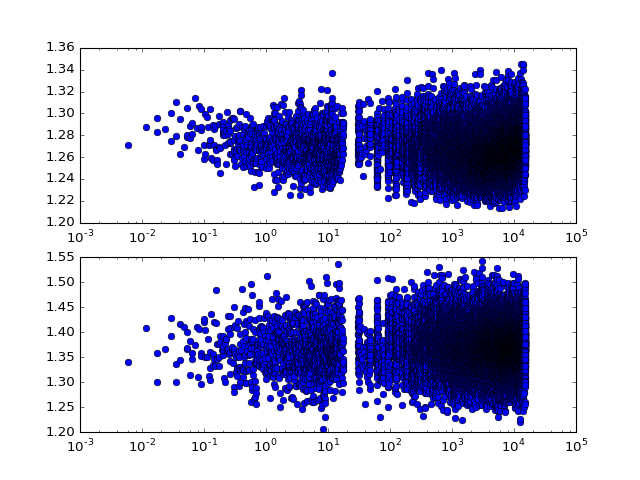

In [96]:
%matplotlib notebook
fig, axes = plt.subplots(2)
axes[0].semilogx(all_time1, g2_time_stamps1[:, 0], 'o')
axes[1].semilogx(all_time1, g2_time_stamps1[:, 1], 'o')
plt.show()

## Getting the g2 with time differnce 

In [513]:
t_diff[50]

29.821098804473877

In [514]:
g2_2, all_time_2 = one_time_using_time_stamps(stack[1:3],
                                                      t_diff[51:151],
                                                      label_array,100)

<IPython.core.display.Javascript object>


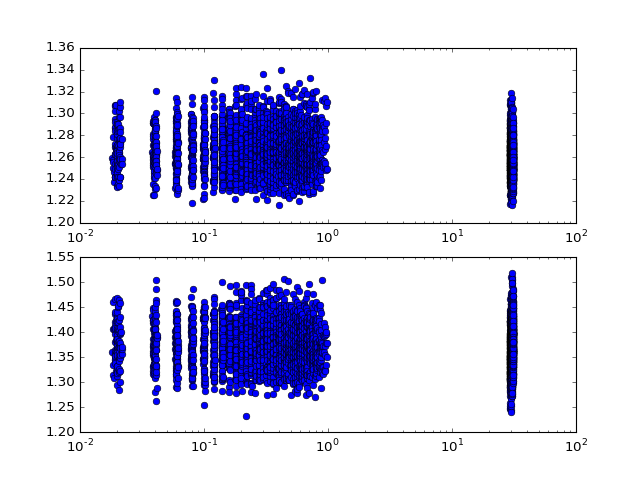

In [515]:
fig, axes = plt.subplots(2)
axes[0].semilogx(all_time_2, g2_2[:, 0], 'o')
axes[1].semilogx(all_time_2, g2_2[:, 1], 'o')
plt.show()

In [516]:
g2_2r, all_time_2r = one_time_using_time_stamps(stack[1:3],
                                                      t_diff_r[51:151],
                                                      label_array,100)

<IPython.core.display.Javascript object>


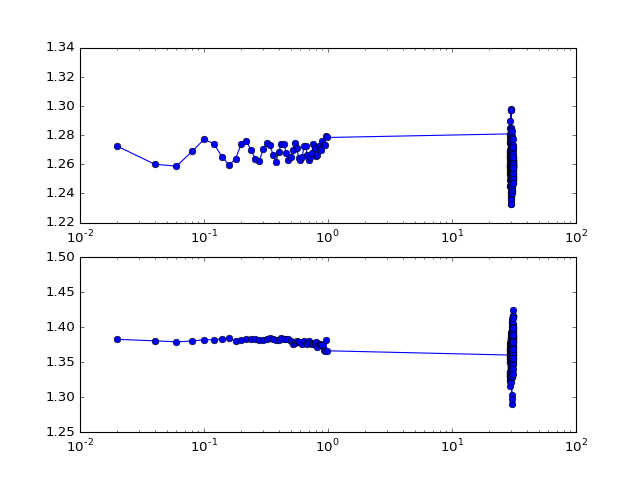

In [517]:
fig, axes = plt.subplots(2)
axes[0].semilogx(all_time_2r, g2_2r[:, 0], '-o')
axes[1].semilogx(all_time_2r, g2_2r[:, 1], '-o')
plt.show()

In [562]:
np.savez("g2_2.npz", g2_2r, all_time_2r)

In [565]:
g2_5_r, all_time_5r = one_time_using_time_stamps(stack[1:6],
                                                      t_diff_r[51:301],
                                                      label_array, 250)

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


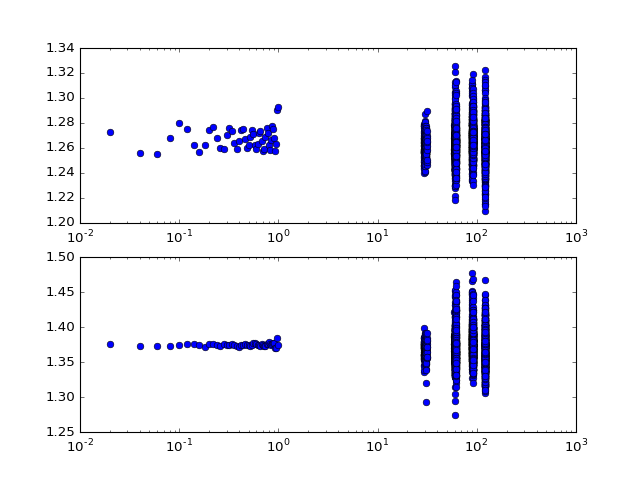

In [566]:
fig, axes = plt.subplots(2)
axes[0].semilogx(all_time_5r, g2_5_r[:, 0], 'o')
axes[1].semilogx(all_time_5r, g2_5_r[:, 1], 'o')
plt.show()

In [567]:
g2_5_rm, g2_5_rm, time_mean_5, time_5 = arrange_g2_variable_time_stamps(all_time_5r, g2_5_r)

/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [568]:
np.savez("g2_50.npz", g2_5_r, all_time_5r,  g2_5_rm, g2_5_rm, time_mean_5, time_5)

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


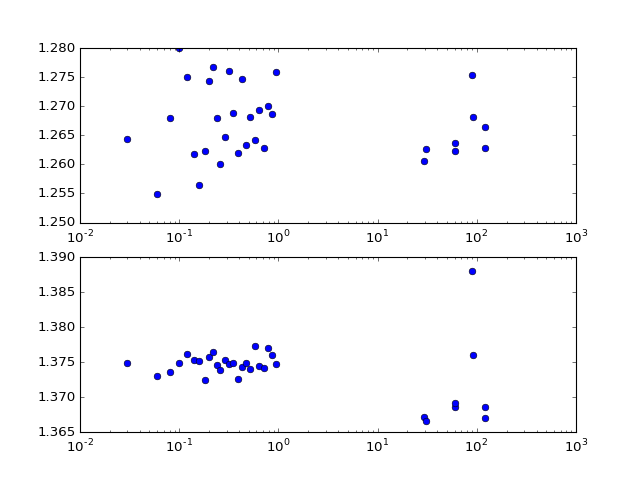

In [569]:
fig, axes = plt.subplots(2)
axes[0].plot(time_5[:-1], g2_5_rm[0][:-1], 'o')
axes[1].plot(time_5[:-1], g2_5_rm[1][:-1], 'o')
axes[0].set_xscale("log")
axes[1].set_xscale("log")
plt.show()

In [559]:
g2_3_r, all_time_3r = one_time_using_time_stamps(stack[1:4],
                                                      t_diff_r[51:201],
                                                      label_array, 150)

In [560]:
np.savez("g2_3.npz", g2_3_r, all_time_3r)

<IPython.core.display.Javascript object>


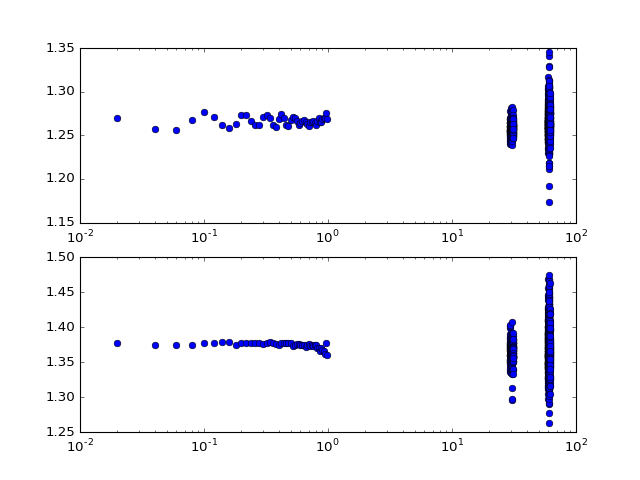

In [525]:
fig, axes = plt.subplots(2)
axes[0].semilogx(all_time_3r, g2_3_r[:, 0], 'o')
axes[1].semilogx(all_time_3r, g2_3_r[:, 1], 'o')
plt.show()

In [526]:
g2_3_rm, g2_3_r_m, time_mean_3, time_3 = arrange_g2_variable_time_stamps(all_time_3r, g2_3_r)

/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


<IPython.core.display.Javascript object>


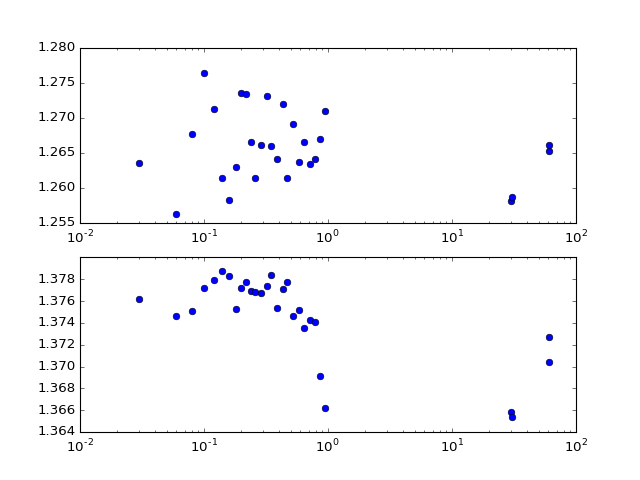

In [530]:
fig, axes = plt.subplots(2)
axes[0].plot(time_3[:-1], g2_3_r_m[0][:-1], 'o')
axes[1].plot(time_3[:-1], g2_3_r_m[1][:-1], 'o')
axes[0].set_xscale("log")
axes[1].set_xscale("log")
plt.show()

In [531]:
g2_100_r, all_time_100r = one_time_using_time_stamps(stack[1:101],
                                                      t_diff_r[51:5051],
                                                      label_array, 5000)

In [558]:
np.savez("g2_100.npz", g2_100_r, all_time_100r, g2_100, lag_steps_100,  g2_100_rm, g2_100_m, time_mean_100, time_100)

In [557]:
np.savez("g2_200.npz", g2_200_r, all_time_200r, g2_200, lag_steps, g2_200_rm, g2_200_m, time_mean_200, time_200)

<IPython.core.display.Javascript object>


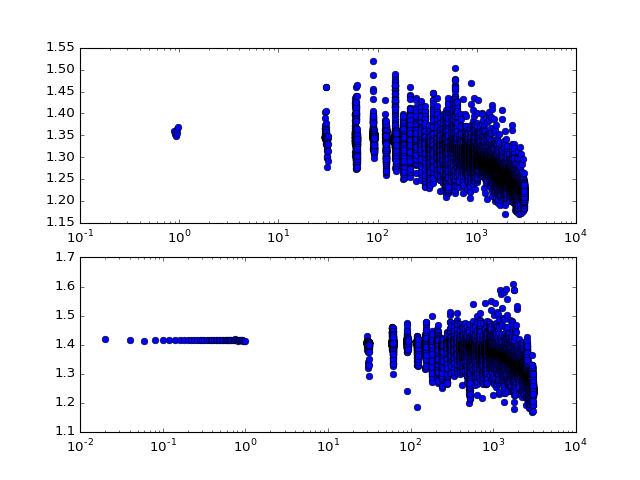

In [532]:
fig, axes = plt.subplots(2)
axes[0].semilogx(all_time_100r, g2_100_r[:, 0], 'o')
axes[1].semilogx(all_time_100r, g2_100_r[:, 1], 'o')
plt.show()

In [ ]:
g2_100_rm, g2_100_m, time_mean_100, time_100 = arrange_g2_variable_time_stamps(all_time_100r, g2_100_r)



<IPython.core.display.Javascript object>


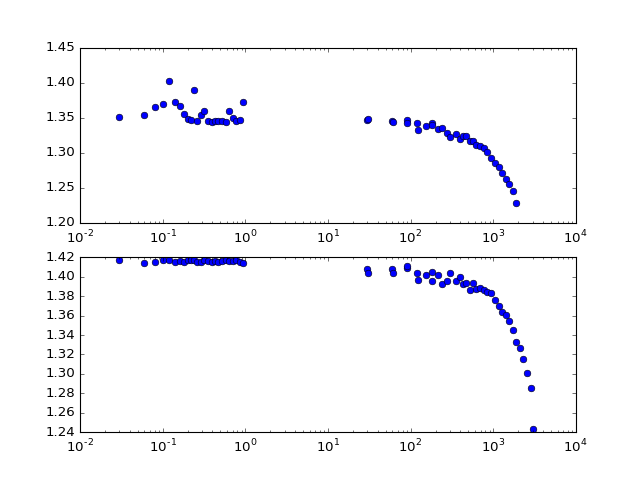

In [539]:
fig, axes = plt.subplots(2)
axes[0].plot(time_100[:-1], g2_100_m[0][:-1], 'o')
axes[1].plot(time_100[:-1], g2_100_m[1][:-1], 'o')
axes[0].set_xscale("log")
axes[1].set_xscale("log")
plt.show()

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


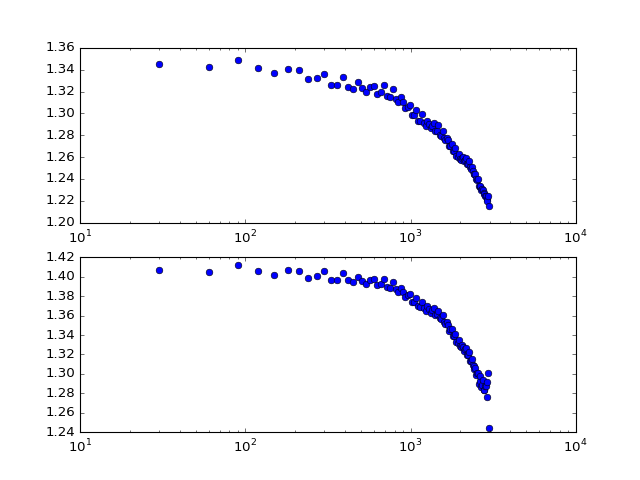

In [553]:
num_lev = 1      # number of levels
num_buf = 100    # number of buffers

g2_100, lag_steps_100 = corr.multi_tau_auto_corr(num_lev, num_buf,
                                         label_array, images_sq[1:101])

lags_100 = lag_steps_100*30   # 30 seconds

fig, axes = plt.subplots(2)
axes[0].semilogx(lags_100, g2_100[:, 0], 'o')
axes[1].semilogx(lags_100, g2_100[:, 1], 'o')
plt.show()


/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


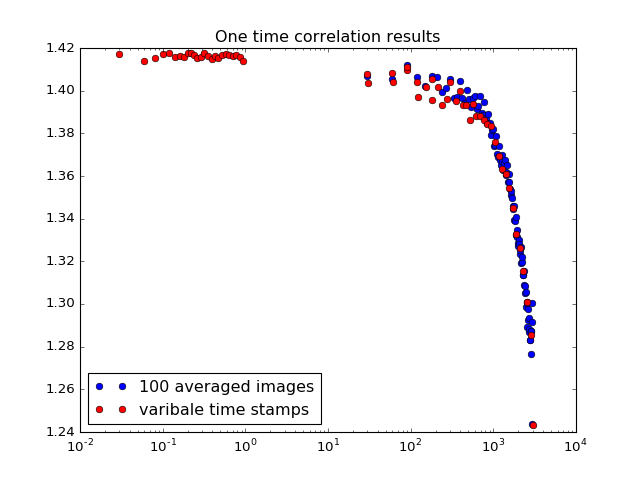

In [564]:
fig, ax = plt.subplots()
ax.semilogx(lags_100, g2_100[:, 1], 'bo', label="100 averaged images")
ax.semilogx(time_100[:-1], g2_100_m[1][:-1], 'ro', label="varibale time stamps")
ax.legend(loc=3)
ax.set_title("One time correlation results")
plt.show()

In [ ]:
g2_200_r, all_time_200r = one_time_using_time_stamps(stack[1:201],
                                                      t_diff_r[51:10051],
                                                      label_array, 10000)


<IPython.core.display.Javascript object>


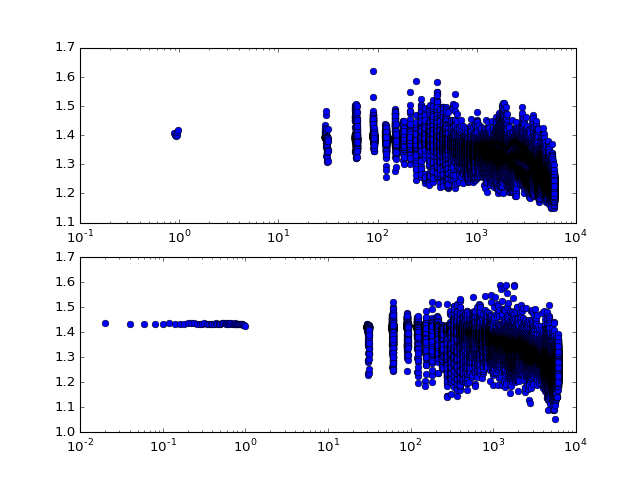

In [540]:
fig, axes = plt.subplots(2)
axes[0].semilogx(all_time_200r, g2_200_r[:, 0], 'o')
axes[1].semilogx(all_time_200r, g2_200_r[:, 1], 'o')
plt.show()

In [541]:
g2_200_rm, g2_200_m, time_mean_200, time_200 = arrange_g2_variable_time_stamps(all_time_200r, g2_200_r)

/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


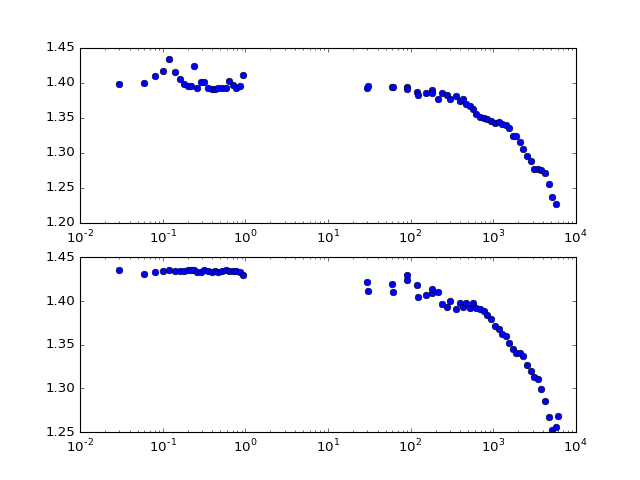

In [542]:
fig, axes = plt.subplots(2)
axes[0].plot(time_200[:-1], g2_200_m[0][:-1], 'o')
axes[1].plot(time_200[:-1], g2_200_m[1][:-1], 'o')
axes[0].set_xscale("log")
axes[1].set_xscale("log")
plt.show()

In [543]:
num_lev = 1      # number of levels
num_buf = 200    # number of buffers

g2, lag_steps = corr.multi_tau_auto_corr(num_lev, num_buf,
                                         label_array, images_sq[1:201])

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


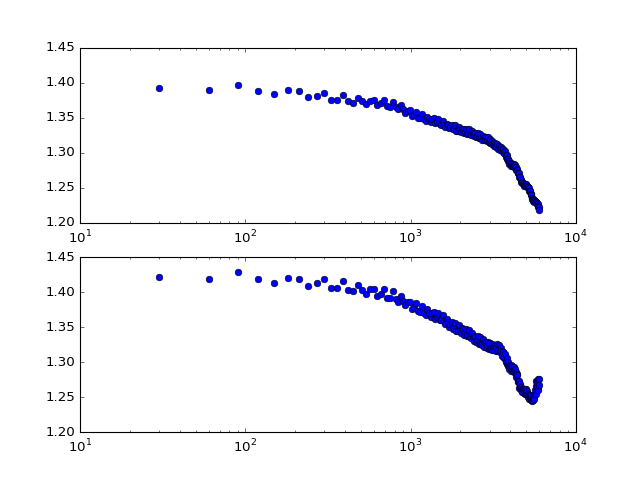

In [544]:
lags = lag_steps*30   # 30 seconds

fig, axes = plt.subplots(2)
axes[0].semilogx(lags, g2[:, 0], 'o')
axes[1].semilogx(lags, g2[:, 1], 'o')
plt.show()

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


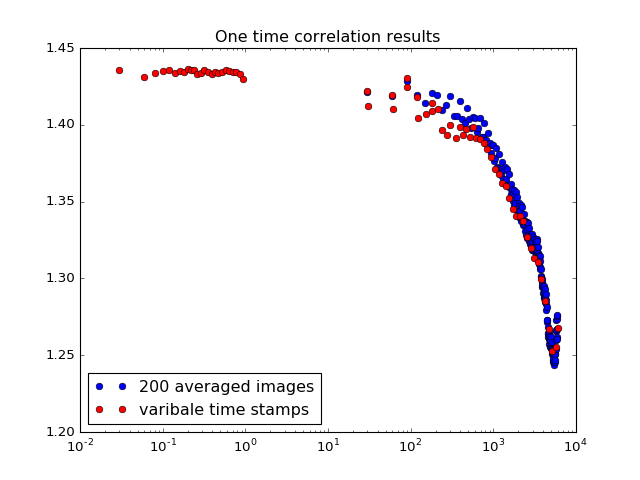

In [563]:
fig, ax = plt.subplots()
ax.semilogx(lags, g2[:, 1], 'bo', label="200 averaged images")
ax.semilogx(time_200[:-1], g2_200_m[1][:-1], 'ro', label="varibale time stamps")
ax.legend(loc=3)
ax.set_title("One time correlation results")
plt.show()

In [362]:
g2_time_stamps22, all_time22 = one_time_using_time_stamps(stack[:10],
                                                      t_diff[:500],
                                                      label_array, 500)

<IPython.core.display.Javascript object>


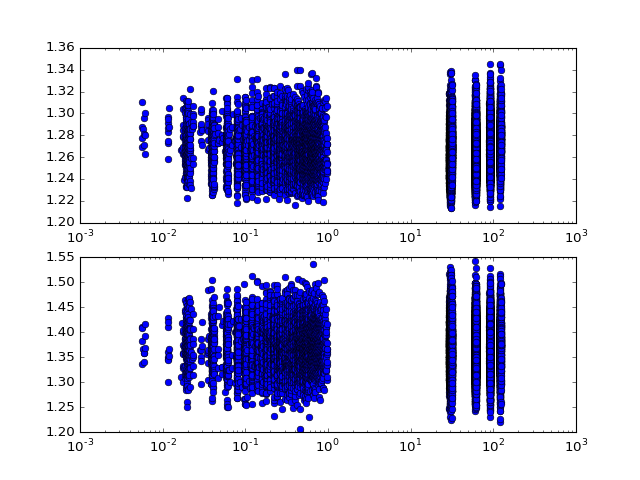

In [444]:
%matplotlib notebook
fig, axes = plt.subplots(2)
axes[0].semilogx(all_time11, g2_time_stamps11[:, 0], 'o')
axes[1].semilogx(all_time11, g2_time_stamps11[:, 1], 'o')
plt.show()

<IPython.core.display.Javascript object>


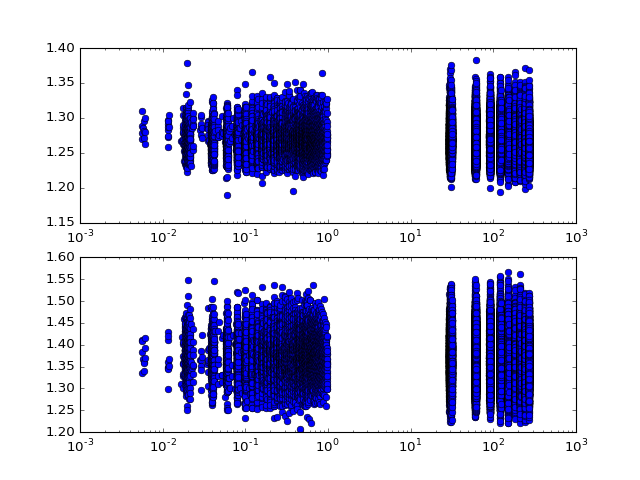

In [363]:
fig, axes = plt.subplots(2)
axes[0].semilogx(all_time22, g2_time_stamps22[:, 0], 'o')
axes[1].semilogx(all_time22, g2_time_stamps22[:, 1], 'o')
plt.show()

<IPython.core.display.Javascript object>


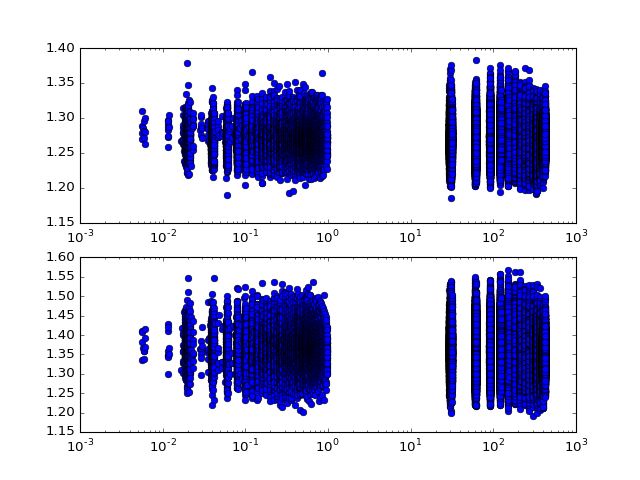

In [367]:
fig, axes = plt.subplots(2)
axes[0].semilogx(all_time15, g2_time_15[:, 0], 'o')
axes[1].semilogx(all_time15, g2_time_15[:, 1], 'o')
plt.show()

In [395]:
g2_time_stamps44.shape, all_time44.shape

((492468, 2), (492468,))

In [368]:
g2_time_stamps44, all_time44 = one_time_using_time_stamps(stack[:20],
                                                      t_diff[:1000],
                                                      label_array, 1000)

<IPython.core.display.Javascript object>


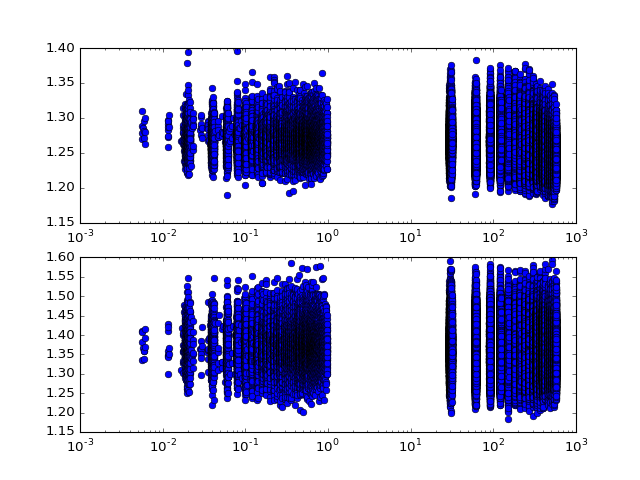

In [369]:
fig, axes = plt.subplots(2)
axes[0].semilogx(all_time44, g2_time_stamps44[:, 0], 'o')
axes[1].semilogx(all_time44, g2_time_stamps44[:, 1], 'o')
plt.show()

In [385]:
g2, g2_mean, time_mean, time = arrange_g2_variable_time_stamps(all_time44, g2_time_stamps44)

/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [387]:
def arrange_g2_variable_time_stamps(time_lags, g2):
    x = np.log(time_lags)[1:]
    y = np.split(x,
                 np.bincount(np.digitize(x,
                                         np.arange(int(np.min(x)),
                                                   int(np.max(x)) + 1,
                                                   0.1))).cumsum())[:-1]
    time = list(filter(None, list(map(list, y))))
    time_array = np.array(time)
    time_mean = [np.mean(a) for a in time_array]
    len_time = [len(a) for a in time_array]
    timing = [0]
    g2_arr = np.zeros([2], np.object)
    g2_arr_mean = np.zeros_like(g2_arr)
    for i, val in enumerate(len_time):
        timing.append(timing[i] + val)
    for k in range(g2.shape[1]):
        g2_ = g2[:, k][~np.isnan(g2[:, k])]
        g2_arr[k] = np.split(g2_[1:], np.array(timing[1:]))
        time = np.split(time_lags[1:], np.array(timing[1:]))
        g2_arr_mean[k] = [np.mean(a) for a in g2_arr[k]]
    time_bin_mean = [np.mean(a) for a in time]
    return g2_arr, g2_arr_mean, time_mean, time_bin_mean

<IPython.core.display.Javascript object>


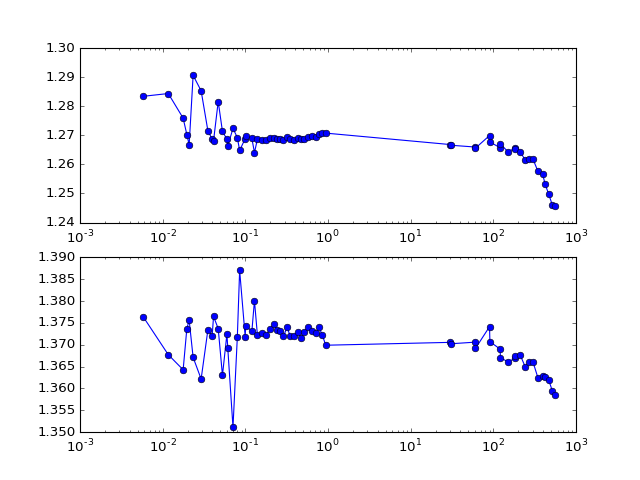

In [388]:
fig, axes = plt.subplots(2)
axes[0].semilogx(time[:-1], g2_mean[0][:-1], '-o')
axes[1].semilogx(time[:-1], g2_mean[1][:-1], '-o')
plt.show()

In [490]:
g2_100, all_time_100 = one_time_using_time_stamps(stack[:100],
                                                      t_diff_r[:5000],
                                                      label_array, 5000)

In [492]:
len(g2_100), len(all_time_100)

(91958, 91958)

<IPython.core.display.Javascript object>


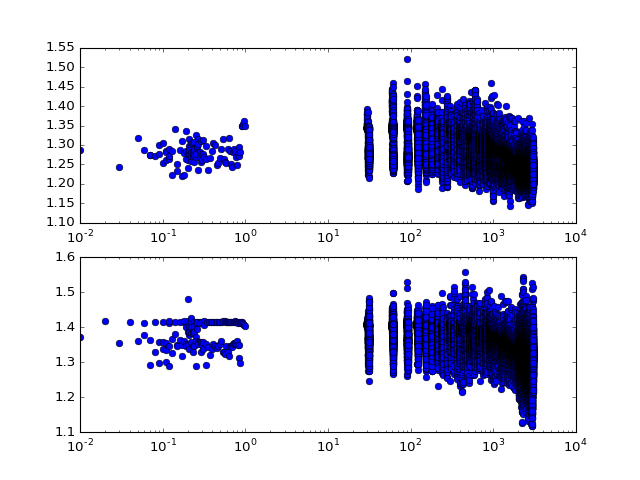

In [493]:
fig, axes = plt.subplots(2)
axes[0].semilogx(all_time_100, g2_100[:, 0], 'o')
axes[1].semilogx(all_time_100, g2_100[:, 1], 'o')
plt.show()

In [494]:
g2_100, g2_mean_100, time_mean, time_100 = arrange_g2_variable_time_stamps(all_time_100,
                                                                           g2_100)

/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


<IPython.core.display.Javascript object>


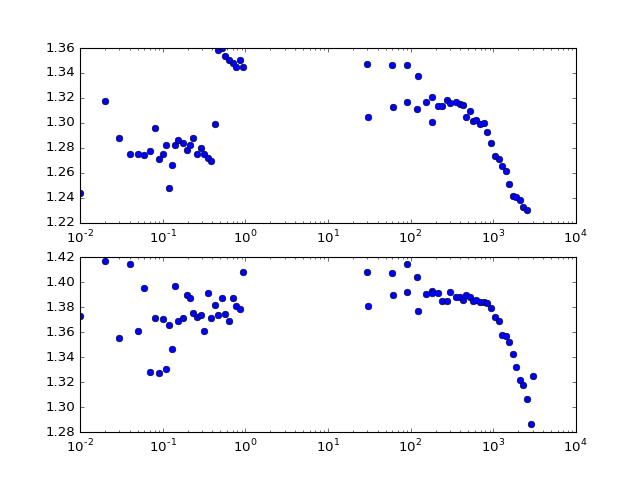

In [496]:
fig, axes = plt.subplots(2)
axes[0].semilogx(time_100[:-1], g2_mean_100[0][:-1], 'o')
axes[1].semilogx(time_100[:-1], g2_mean_100[1][:-1], 'o')
plt.show()

In [ ]:
g2_200, all_time_200 = one_time_using_time_stamps(stack[:200],
                                                      t_diff_r[:10000],
                                                      label_array, 10000)

<IPython.core.display.Javascript object>


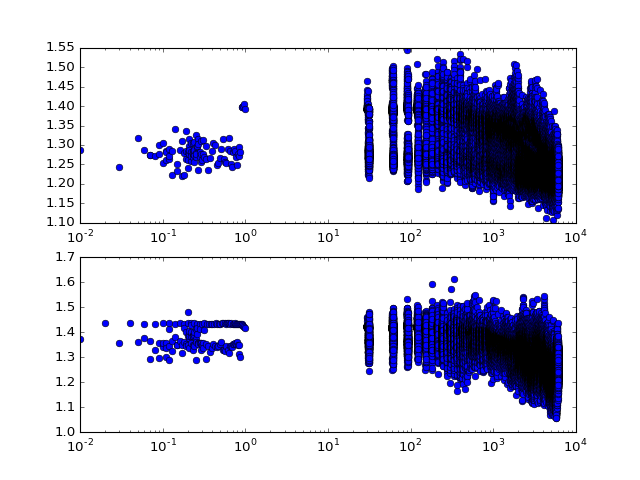

In [499]:
fig, axes = plt.subplots(2)
axes[0].semilogx(all_time_200, g2_200[:, 0], 'o')
axes[1].semilogx(all_time_200, g2_200[:, 1], 'o')
plt.show()

In [500]:
g2_200, g2_mean_200, time_mean_, time_200 = arrange_g2_variable_time_stamps(all_time_200,
                                                                           g2_200)

/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


<IPython.core.display.Javascript object>


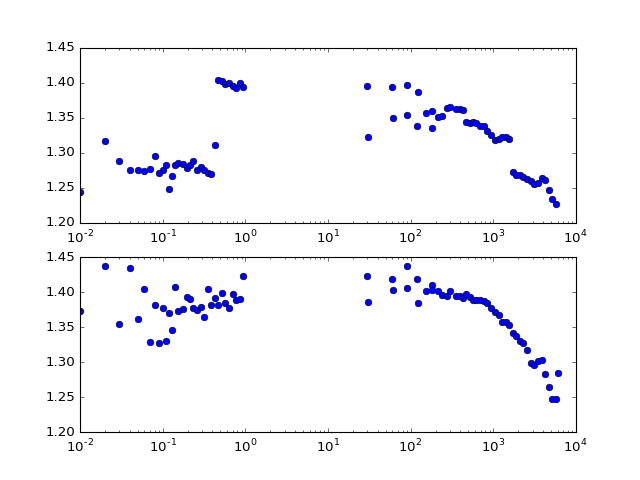

In [501]:
fig, axes = plt.subplots(2)
axes[0].semilogx(time_200[:-1], g2_mean_200[0][:-1], 'o')
axes[1].semilogx(time_200[:-1], g2_mean_200[1][:-1], 'o')
plt.show()

## g2 with time stamps

In [164]:
y =np.array_split(np.log(all_time3)[1:100],8)
y

[array([-5.12036937, -4.45192004, -4.03964305, -4.03815436, -3.75579099,
        -3.53153661, -3.52571938, -3.35049244, -3.34575125, -3.19453197,
        -3.18993539, -3.06095004, -2.9442435 ]),
 array([-2.94100593, -2.93897875, -2.83841184, -2.83675296, -2.741695  ,
        -2.74112557, -2.65333006, -2.57384787, -2.51105288, -2.50015232,
        -2.43178693, -2.43021732, -2.42989233]),
 array([-2.30495874, -2.2909677 , -2.24920156, -2.24741305, -2.19428443,
        -2.14438908, -2.11160674, -2.09573743, -2.09488186, -2.09464945,
        -2.0475229 , -1.95943912, -1.95794903]),
 array([-1.92659197, -1.91965232, -1.88048963, -1.84338053, -1.84317419,
        -1.82503965, -1.80613475, -1.73785464, -1.73784379, -1.73724555,
        -1.70782353, -1.70182061]),
 array([-1.64247201, -1.61216174, -1.60325615, -1.58884031, -1.58397837,
        -1.58262483, -1.55527603, -1.50859321, -1.50412413, -1.50173916,
        -1.47483226, -1.45020137]),
 array([-1.42242008, -1.40071439, -1.39912746, -1.3

In [163]:
np.log(all_time)[25000:30000]

array([ 9.12962652,  9.12963964,  9.12965061, ...,  9.53030235,
        9.53039585,  9.53046766])

In [217]:
np.arange(-5, 12, 0.1)

array([ -5.00000000e+00,  -4.90000000e+00,  -4.80000000e+00,
        -4.70000000e+00,  -4.60000000e+00,  -4.50000000e+00,
        -4.40000000e+00,  -4.30000000e+00,  -4.20000000e+00,
        -4.10000000e+00,  -4.00000000e+00,  -3.90000000e+00,
        -3.80000000e+00,  -3.70000000e+00,  -3.60000000e+00,
        -3.50000000e+00,  -3.40000000e+00,  -3.30000000e+00,
        -3.20000000e+00,  -3.10000000e+00,  -3.00000000e+00,
        -2.90000000e+00,  -2.80000000e+00,  -2.70000000e+00,
        -2.60000000e+00,  -2.50000000e+00,  -2.40000000e+00,
        -2.30000000e+00,  -2.20000000e+00,  -2.10000000e+00,
        -2.00000000e+00,  -1.90000000e+00,  -1.80000000e+00,
        -1.70000000e+00,  -1.60000000e+00,  -1.50000000e+00,
        -1.40000000e+00,  -1.30000000e+00,  -1.20000000e+00,
        -1.10000000e+00,  -1.00000000e+00,  -9.00000000e-01,
        -8.00000000e-01,  -7.00000000e-01,  -6.00000000e-01,
        -5.00000000e-01,  -4.00000000e-01,  -3.00000000e-01,
        -2.00000000e-01,

In [316]:
g2 = np.zeros([2], np.object)
for k in range(g2_time_stamps3.shape[1]):
    g2[k] = 1

In [267]:
l = [0.1, 0.32, 0.35 ,0.4, 0.5, 0.6, 0.7]
x = np.log(all_time3)[1:]
y = np.split(x, np.bincount(np.digitize(x, np.arange(int(np.min(x)),
                                                     int(np.max(x)) + 1,
                                                     0.1))).cumsum())[:-1]
time = list(filter(None, list(map(list, y))))

len(time)

150

In [268]:
int(np.min(np.log(all_time3)[1:]))

-5

In [324]:
g2_time_stamps3.shape

(280127, 2)

In [323]:
g2_time_stamp3_ = g2_time_stamps3[~np.isnan(g2_time_stamps3)]
g2_time_stamp3_.shape

(559505,)

In [328]:
time_array= np.array(time)

time_mean = [np.mean(a) for a in time_array]
len_time = [len(a) for a in time_array]
timing = [0]
g2_time_stamp3_ = g2_time_stamps3[~np.isnan(g2_time_stamps3)]
for i, val in enumerate(len_time):
        timing.append(timing[i] + val)
g2_arr_mean = np.zeros([2], np.object)
for k in range(g2_time_stamps3.shape[1]):
    
    
    g2_arr[k] = np.split(g2_[1:], np.array(timing[1:]))
    g2_arr_mean[k] = [np.mean(a) for a in g2_arr[k]]

/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


<IPython.core.display.Javascript object>


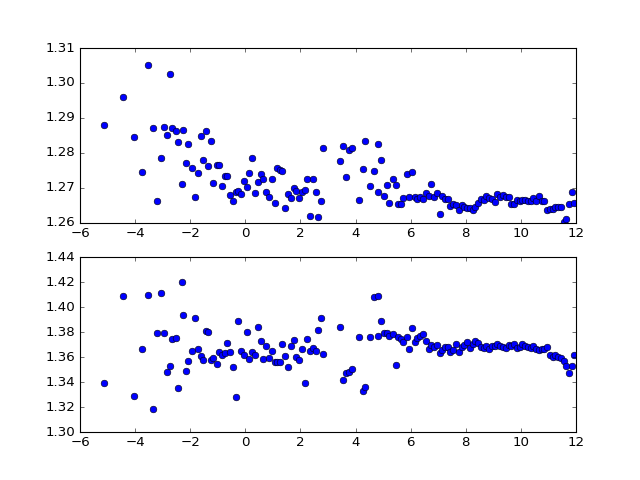

In [338]:
fig, axes = plt.subplots(2)
axes[0].plot(time_mean, g2_arr_mean[0][:-1], 'o')
axes[1].plot(time_mean, g2_arr_mean[1][:-1], 'o')
plt.show()

In [332]:
g2_arr[1][-1], g2_time_stamps[:, 1][-1]

(array([], dtype=float64), 1.3319733156178883)

In [270]:
len(time_array)

150

In [344]:
all_time3[:150], np.log(all_time3[:100])

(array([ 0.        ,  0.00597382,  0.01165617,  0.01760375,  0.01762998,
         0.02338195,  0.02925992,  0.02943063,  0.03506708,  0.03523374,
         0.0409857 ,  0.04117453,  0.04684317,  0.05264187,  0.05281258,
         0.05291975,  0.05851853,  0.05861568,  0.06446099,  0.06449771,
         0.07041633,  0.07624161,  0.08118272,  0.0820725 ,  0.08787966,
         0.0880177 ,  0.08804631,  0.09976292,  0.10116851,  0.10548341,
         0.10567224,  0.11143827,  0.11713958,  0.12104332,  0.12297952,
         0.12308478,  0.12311339,  0.12905419,  0.14093745,  0.14114761,
         0.14564371,  0.14665794,  0.15251541,  0.15828145,  0.15831411,
         0.16121125,  0.16428792,  0.17589736,  0.17589927,  0.17600453,
         0.18125987,  0.18235123,  0.19350111,  0.19945598,  0.20124018,
         0.20416224,  0.20515728,  0.20543516,  0.2111311 ,  0.22122097,
         0.22221184,  0.22274244,  0.22881711,  0.23452306,  0.24112976,
         0.24642086,  0.24681222,  0.25708199,  0.2

In [212]:
g2_time_stamps3[time==3]

/opt/conda_envs/analysis/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: DeprecationWarning: using a boolean instead of an integer will result in an error in the future
  if __name__ == '__main__':


array([       nan,  1.4804743])

In [213]:
g2_time_stamps3[:4], all_time3[:4]

(array([[        nan,  1.4804743 ],
        [ 1.27090824,  1.33943939],
        [ 1.28782924,  1.40906562],
        [ 1.29593138,  1.35848091]]),
 array([ 0.        ,  0.00597382,  0.01165617,  0.01760375]))

<IPython.core.display.Javascript object>


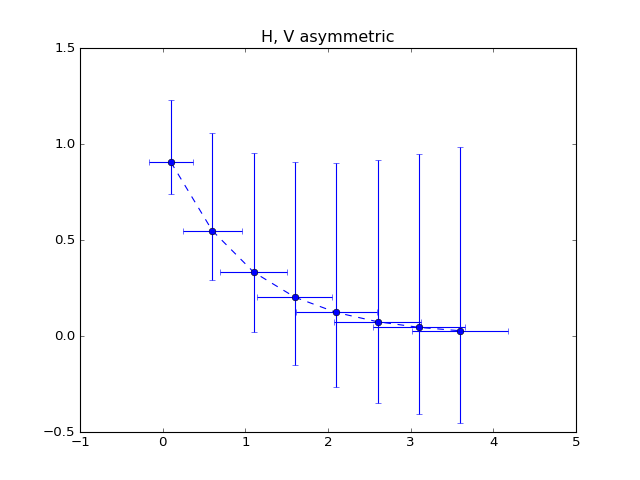

In [151]:
# example data
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)

# example variable error bar values
yerr = 0.1 + 0.2*np.sqrt(x)
xerr = 0.1 + yerr

fig, ax = plt.subplots()
ax.errorbar(x, y, yerr=[yerr, 2*yerr], xerr=[xerr, xerr], fmt='--o')
ax.set_title('H, V asymmetric')


In [153]:
yerr = 0.1 + 0.2*np.sqrt(x)
yerr

array([ 0.16324555,  0.25491933,  0.30976177,  0.35298221,  0.38982753,
        0.42249031,  0.45213634,  0.47947332])

In [ ]:
def group_variable_time_lags(time_lags):
    list(map(int, np.log(time_lags)[1:]))

In [ ]:
def plot_g2_variable_time(time_lags, g2):
    

In [99]:
all_time, np.log(all_time)

(array([  0.00000000e+00,   5.97381592e-03,   1.16561651e-02, ...,
          1.51974130e+04,   1.51974247e+04,   1.51974307e+04]),
 array([       -inf, -5.12036937, -4.45192004, ...,  9.6288805 ,
         9.62888126,  9.62888166]))

In [114]:
np.log(all_time3)[1:]

array([ -5.12036937,  -4.45192004,  -4.03964305, ...,  11.97725128,
        11.97725135,  11.97725139])